In [10]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['ATEN_CPU_CAPABILITY'] = 'default'

In [11]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [12]:
# build the vocabulary of chars and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [13]:
# build the dataset
block_size = 3

def build_dataset(words):    
    X, Y = [], []
    for w in words:
        context= [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            #print(''.join(itos[i] for i in context), '----->', itos[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [15]:
n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),  generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1
b2 = torch.randn(vocab_size,                        generator=g) * 0.1
# Batchnorm params
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [16]:
batch_size = 32
n = batch_size
# construct mini-batch
idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[idx], Ytr[idx]

In [17]:
# forward pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear layer 1
hprebn = embcat @ W1 + b1
# Batch norm
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)
# Linear layer 2
logits = h @ W2 + b2
# cross entropy loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # normalise logits by taking max_val - val (so we don't run out of floating point space)
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Backwards pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3490, grad_fn=<NegBackward0>)

In [34]:
# Exercise 1: backprop through the whole thing

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dlogits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += 2.0 * bndiff * dbndiff2
dhprebn = dbndiff.clone() 
dbnmeani = (-dbndiff).sum(0)
dhprebn += (1.0 / n) * (dbnmeani * torch.ones_like(hprebn))
dembcat =  dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        idx = Xb[k,j]        
        dC[idx] += demb[k, j]        

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [52]:
# This is all much simpler
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.349043846130371 diff: 0.0


In [67]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.2177499532699585e-09


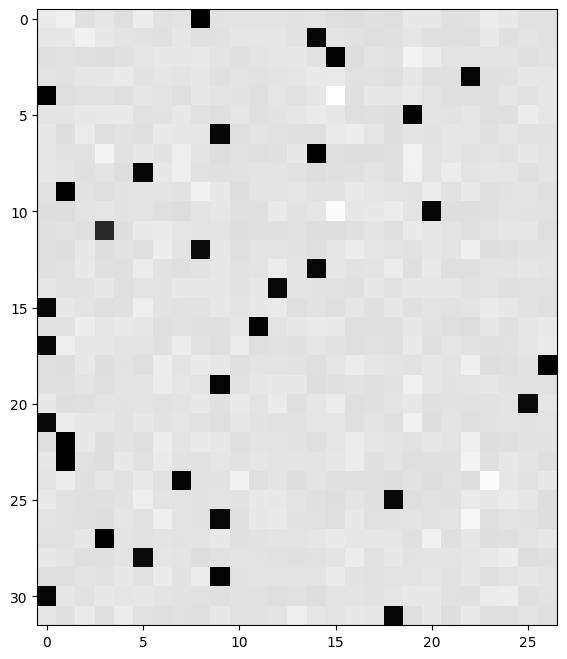

In [68]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [64]:
# backprop through batch norm in a single pass
#
# forward pass
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [69]:
# backwards pass

# before we had
# dbnraw = bngain * dhpreact
# dbnbias = dhpreact.sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
# dbndiff += 2.0 * bndiff * dbndiff2
# dhprebn = dbndiff.clone() 
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += (1.0 / n) * (dbnmeani * torch.ones_like(hprebn))

dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [ ]:
# putting it all togetehr